# Rescaling an equilibrium and coils

The following shows you how to rescale an equilibrium and coilset. 

In [16]:
from desc.compat import rescale
from desc.io import load
from desc.plotting import plot_3d, plot_coils, plot_surfaces, poincare_plot
from desc.grid import LinearGrid
import desc
import numpy as np


def plot_field_lines(field, eq):
    # for starting locations we'll pick positions on flux surfaces on the outboard midplane
    grid_trace = LinearGrid(rho=np.linspace(0, 1, 9))
    r0 = eq.compute("R", grid=grid_trace)["R"]
    z0 = eq.compute("Z", grid=grid_trace)["Z"]
    fig, ax = plot_surfaces(eq)
    fig, ax, data = poincare_plot(
        field, r0, z0, NFP=eq.NFP, ax=ax, color="k", size=1, return_data=True
    )
    return fig, ax, data

In [17]:
# BEFORE SCALING

# loading outputs from the examples
eq = load("precise_QA_output.h5")[-1]
coilset = load("optimized_coilset.h5")

# printing attributes and plotting
a = eq.compute("a")["a"]
R0 = eq.compute("R0")["R0"]
B_on_axis = eq.compute("<|B|>_axis")["<|B|>_axis"]
vol = eq.compute("V")["V"]

print(f"B = {B_on_axis} T")
print(f"R = {R0} m")
print(
    f"a = {a} m",
)
print(f"vol = {vol}")

fig = plot_3d(eq, "B")
plot_coils(coilset, fig=fig)
fig.show()

B = 0.7063946343014657 T
R = 1.0294372105788399 m
a = 0.20588745006389125 m
vol = 0.8613692289369244


/Users/leoduan/.pyenv/versions/3.12.12/lib/python3.12/site-packages/desc/utils.py:572: UserWarning:

Unequal number of field periods for grid 1 and basis 2.

/Users/leoduan/.pyenv/versions/3.12.12/lib/python3.12/site-packages/desc/utils.py:572: UserWarning:

Unequal number of field periods for grid 1 and basis 2.



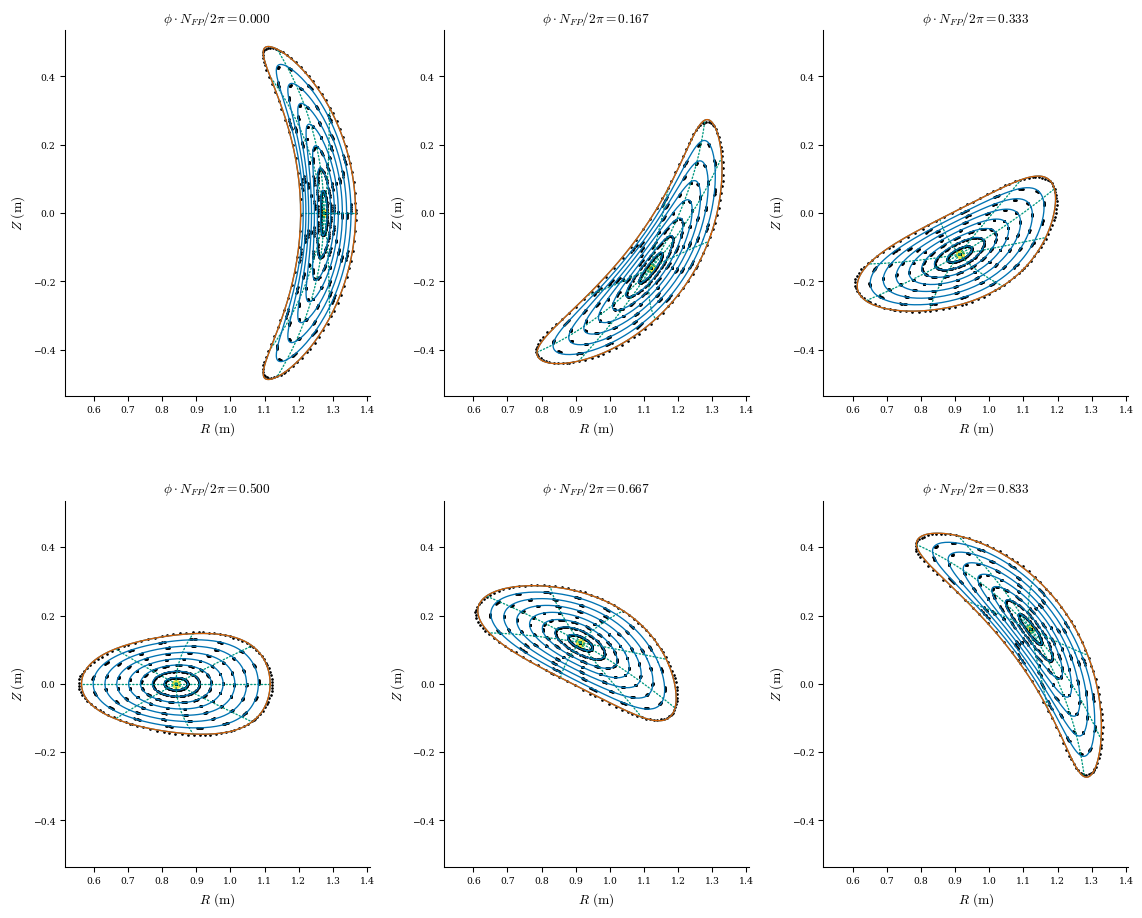

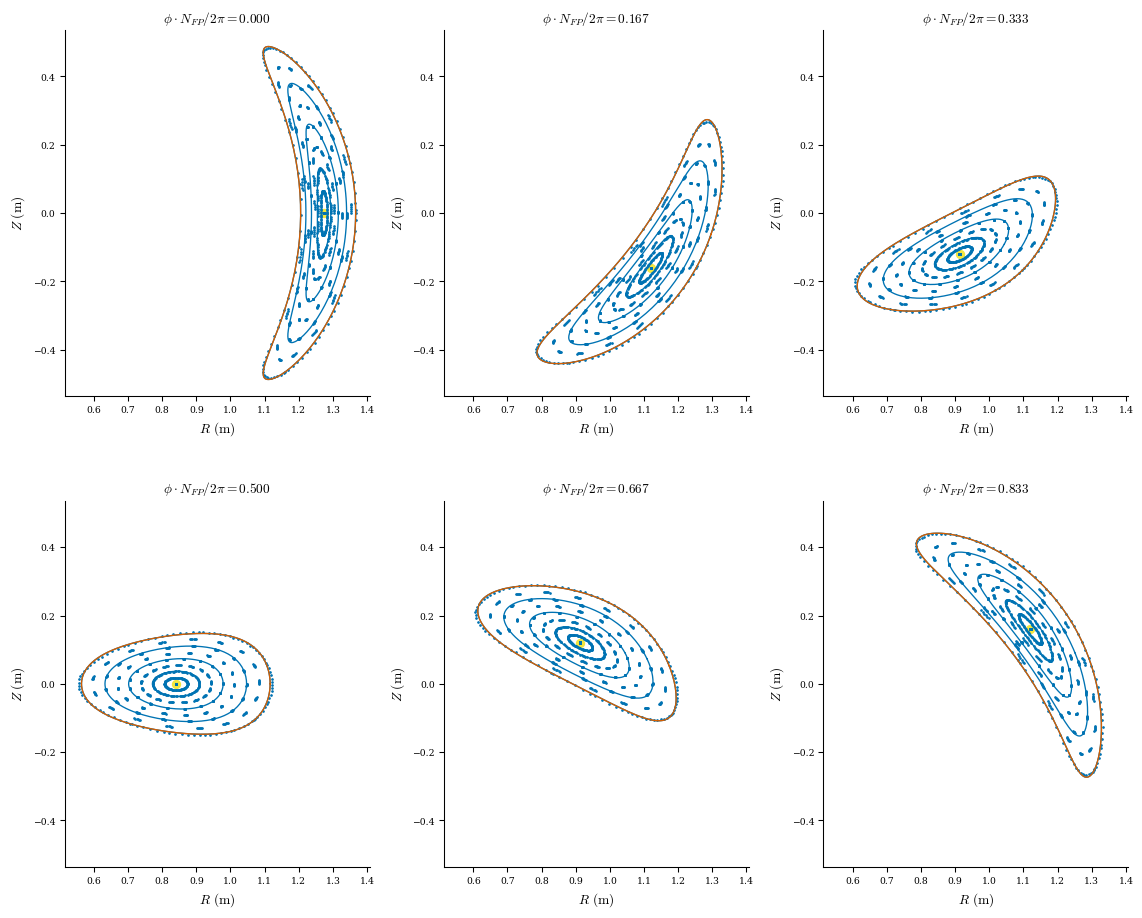

In [18]:
_, _, data_trace = plot_field_lines(coilset, eq)

fig, ax = plot_surfaces(eq, theta=0, rho=4)
for i, axx in enumerate(ax):
    axx.scatter(data_trace["R"][:, i, :], data_trace["Z"][:, i, :], s=1)

## Rescaling the equilibrium

We use the `desc.compat.rescale` function to rescale the equilibrium. In this block, I compute the scaling factor as target_R0/R0; if you instead want to scale to a target volume, the scaling factor L has to be taken to the power 1/3—this is important for rescaling the coils!


In [19]:
# AFTER SCALING

# scaling outputs from the examples. For our hackathon, we compute B in our tau_E
# using B on axis, so rescale B0.

target_R0 = 3
target_B = 5

eq_rescaled = rescale(eq=eq, L=("R0", target_R0), B=("B0", target_B))

scaling_factor_L = target_R0 / R0
scaling_factor_B = target_B / B_on_axis

## if you want to scale by volume instead:
# scaling_factor_L = (target_V/V)**(1/3)
# scaling_factor_B = target_B/B_on_axis

"""
desc.compat.rescale Parameters
----------
eq : Equilibrium or iterable of Equilibrium
    Equilibria to rescale.
L : tuple, (str, float)
    First element is a string denoting the length to scale. One of:
    {"R0", "a", "V"} for major radius, minor radius, or volume.
    Second element is a float denoting the desired size. Default is no scaling.
B : tuple, (str, float)
    First element is a string denoting the magnetic field strength to scale. One of:
    {"B0", "<B>", "B_max"} for B on axis, volume averaged, or maximum on the LCFS.
    Second element is a float denoting the desired field. Default is no scaling.
scale_pressure : bool, optional
    Whether or not to scale the pressure profile to maintain force balance.
copy : bool, optional
    Whether to rescale the original equilibrium (default) or a copy.
verbose : int
    Level of output.
"""

'\ndesc.compat.rescale Parameters\n----------\neq : Equilibrium or iterable of Equilibrium\n    Equilibria to rescale.\nL : tuple, (str, float)\n    First element is a string denoting the length to scale. One of:\n    {"R0", "a", "V"} for major radius, minor radius, or volume.\n    Second element is a float denoting the desired size. Default is no scaling.\nB : tuple, (str, float)\n    First element is a string denoting the magnetic field strength to scale. One of:\n    {"B0", "<B>", "B_max"} for B on axis, volume averaged, or maximum on the LCFS.\n    Second element is a float denoting the desired field. Default is no scaling.\nscale_pressure : bool, optional\n    Whether or not to scale the pressure profile to maintain force balance.\ncopy : bool, optional\n    Whether to rescale the original equilibrium (default) or a copy.\nverbose : int\n    Level of output.\n'

## Rescaling the coils

We have to scale the size of the coils, as well as the current. We use the scaling factors that we computed in the last step. 

Equilibrium toroidal flux enclosed by LCFS: 5.229737939735667 Wb
Coilset toroidal flux enclosed by LCFS: 0.21306869764499037 Wb
Coilset currents should be multiplied by 24.545 in order to be consistent with the equilibrium


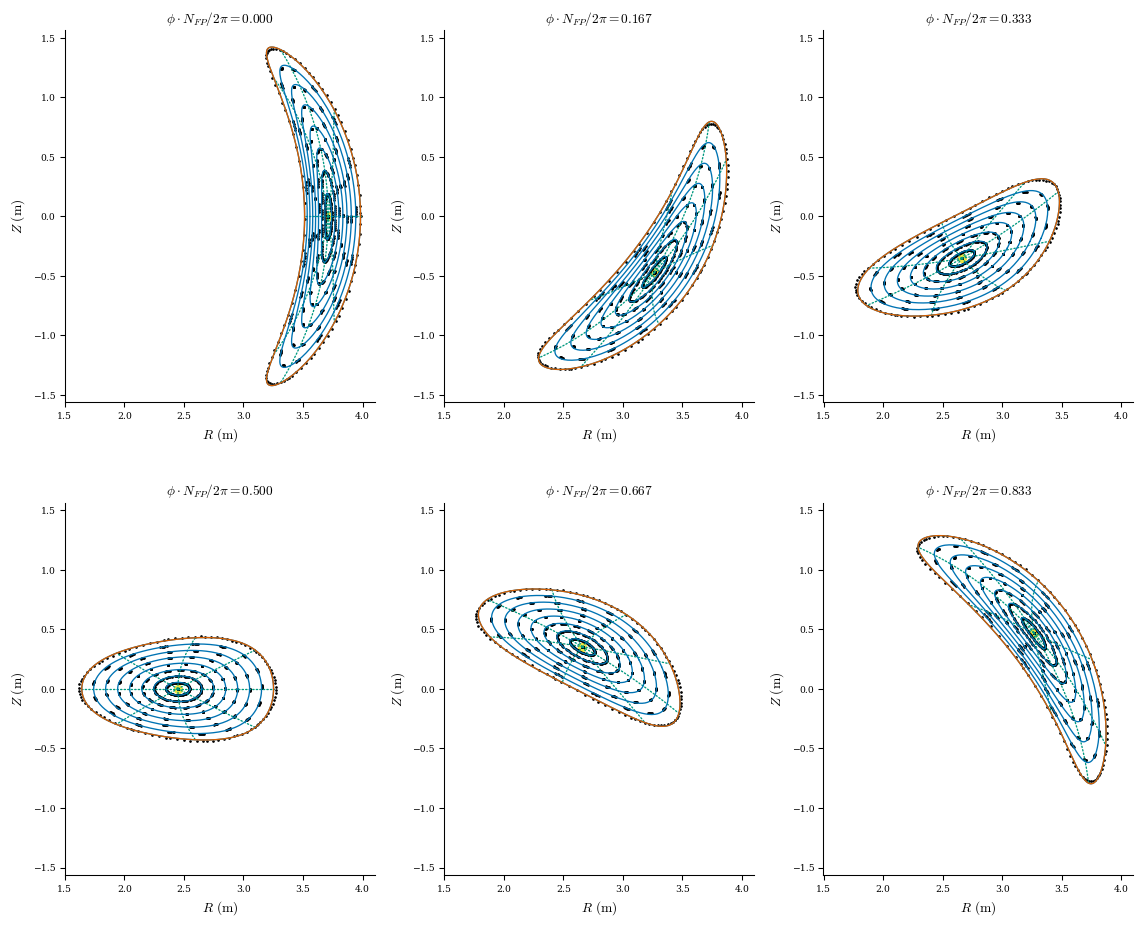

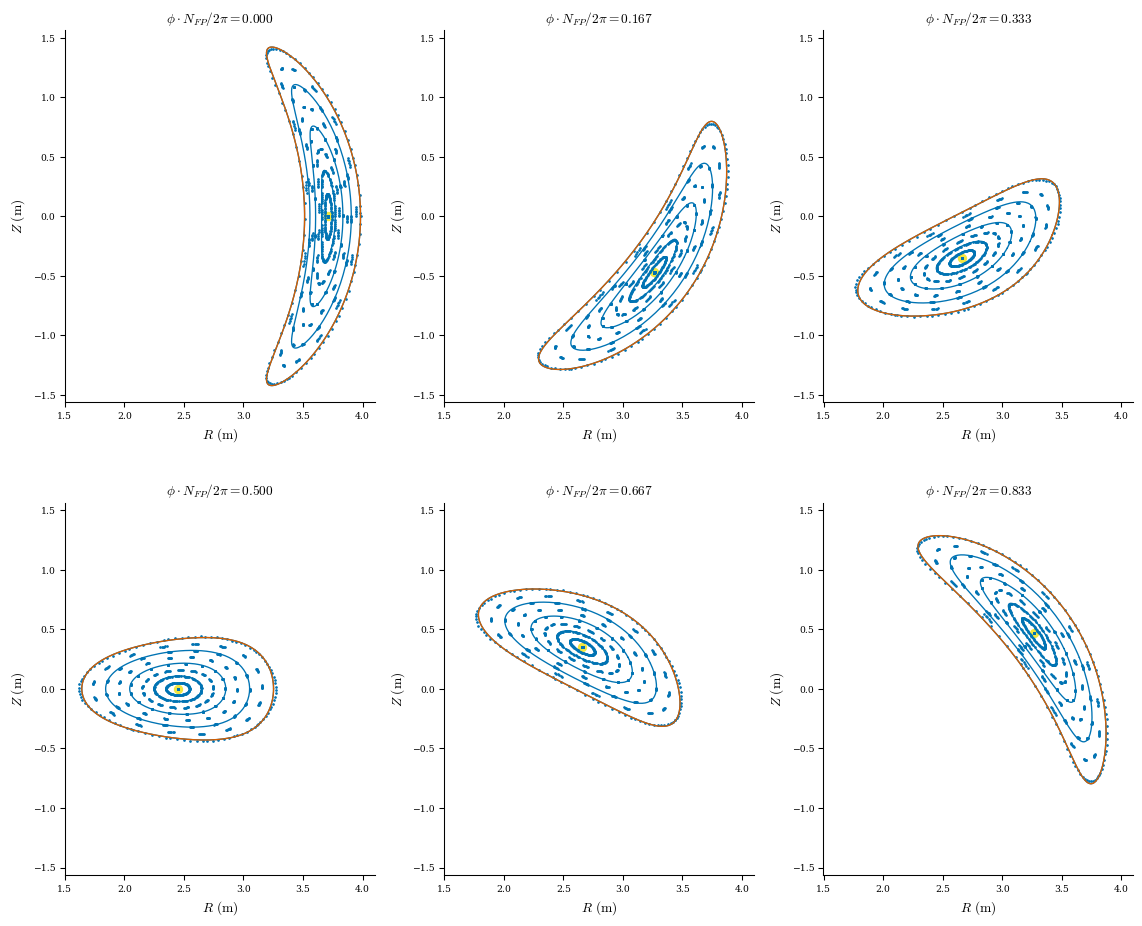

In [20]:
rescaled_coilset = coilset.copy()

# Scaling size of the coils
for coil in rescaled_coilset:
    coil.X_n *= scaling_factor_L
    coil.Y_n *= scaling_factor_L
    coil.Z_n *= scaling_factor_L

# Scaling current (do this AFTER rescaling size!)

grid = LinearGrid(L=50, M=50, zeta=np.array(0.0))
data = eq_rescaled.compute(["R", "phi", "Z", "|e_rho x e_theta|"], grid=grid)
field_B = rescaled_coilset.compute_magnetic_field(
    np.vstack([data["R"], data["phi"], data["Z"]]).T, source_grid=LinearGrid(N=200)
)
coil_Psi = np.sum(
    grid.spacing[:, 0] * grid.spacing[:, 1] * data["|e_rho x e_theta|"] * field_B[:, 1]
)

print(f"Equilibrium toroidal flux enclosed by LCFS: {eq_rescaled.Psi} Wb")
print(f"Coilset toroidal flux enclosed by LCFS: {coil_Psi} Wb")

current_scale_factor = eq_rescaled.Psi / coil_Psi
print(
    f"Coilset currents should be multiplied by {current_scale_factor:1.3f} in order to be consistent with the equilibrium"
)

_, _, data_trace = plot_field_lines(rescaled_coilset, eq_rescaled)

fig, ax = plot_surfaces(eq_rescaled, theta=0, rho=4)
for i, axx in enumerate(ax):
    axx.scatter(data_trace["R"][:, i, :], data_trace["Z"][:, i, :], s=1)

In [23]:
rescaled_coilset.save("optimized_coilset_scaled.h5")